https://www.statsmodels.org/dev/vector_ar.html

## Vector Autoregression (VAR)

Vector Autoregression (VAR) is a forecasting algorithm that can be used when two or more time series influence each other.

The VAR class assumes that the passed time series are stationary.\
Non-stationary or trending data can often be transformed to be stationary by first-differencing or some other method.\
For direct analysis of non-stationary time series, a standard stable VAR(p) model is not appropriate.

To actually do the estimation, call the fit method with the desired lag order.\
Or you can have the model select a lag order based on a standard information criterion (see below).

In [1]:
import numpy as np
import pandas
import statsmodels.api as sm

from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

In [2]:
mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)

In [3]:
dates

,year,quarter
0,1959,1
1,1959,2
2,1959,3
3,1959,4
4,1960,1
...,...,...
198,2008,3
199,2008,4
200,2009,1
201,2009,2


In [4]:
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)

mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pandas.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()

# make a VAR model
model = VAR(data)

/home/alexis/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


Data:

year      - 1959q1 - 2009q3\
quarter   - 1-4\
realgdp   - Real gross domestic product (Bil. of chained 2005 US$,
            seasonally adjusted annual rate)\
realcons  - Real personal consumption expenditures (Bil. of chained
            2005 US$, seasonally adjusted annual rate)\
realinv   - Real gross private domestic investment (Bil. of chained
            2005 US$, seasonally adjusted annual rate)

In [5]:
mdata

,realgdp,realcons,realinv
1959-03-31,2710.349,1707.4,286.898
1959-06-30,2778.801,1733.7,310.859
1959-09-30,2775.488,1751.8,289.226
1959-12-31,2785.204,1753.7,299.356
1960-03-31,2847.699,1770.5,331.722
...,...,...,...
2008-09-30,13324.600,9267.7,1990.693
2008-12-31,13141.920,9195.3,1857.661
2009-03-31,12925.410,9209.2,1558.494
2009-06-30,12901.504,9189.0,1456.678


Text(0, 0.5, 'Real GDP')

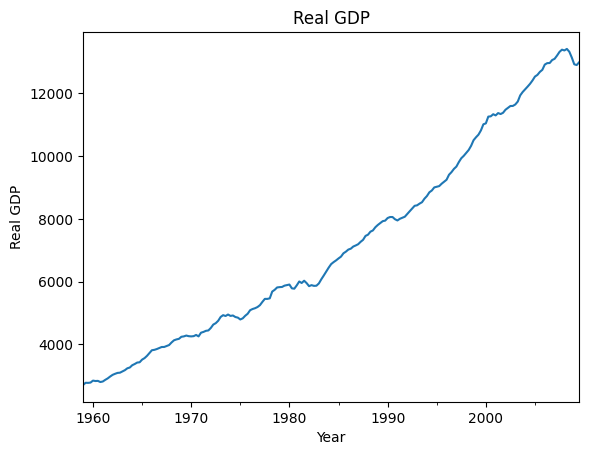

In [14]:
ax = mdata['realgdp'].plot()
ax.set_title("Real GDP")
ax.set_xlabel("Year")
ax.set_ylabel("Real GDP")

Text(0, 0.5, 'log(GDP)-log(GDPlast)')

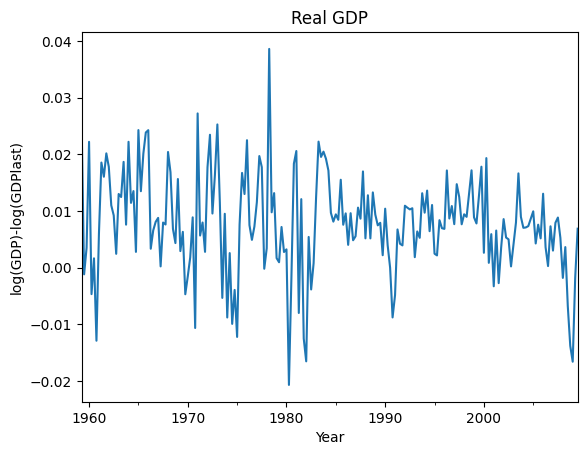

In [17]:
ax = data['realgdp'].plot()
ax.set_title("Real GDP")
ax.set_xlabel("Year")
ax.set_ylabel("log(GDP)-log(GDPlast)")

In [18]:
# We fit the model AR(2)
results = model.fit(2)

In [19]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Aug, 2024
Time:                     09:14:25
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

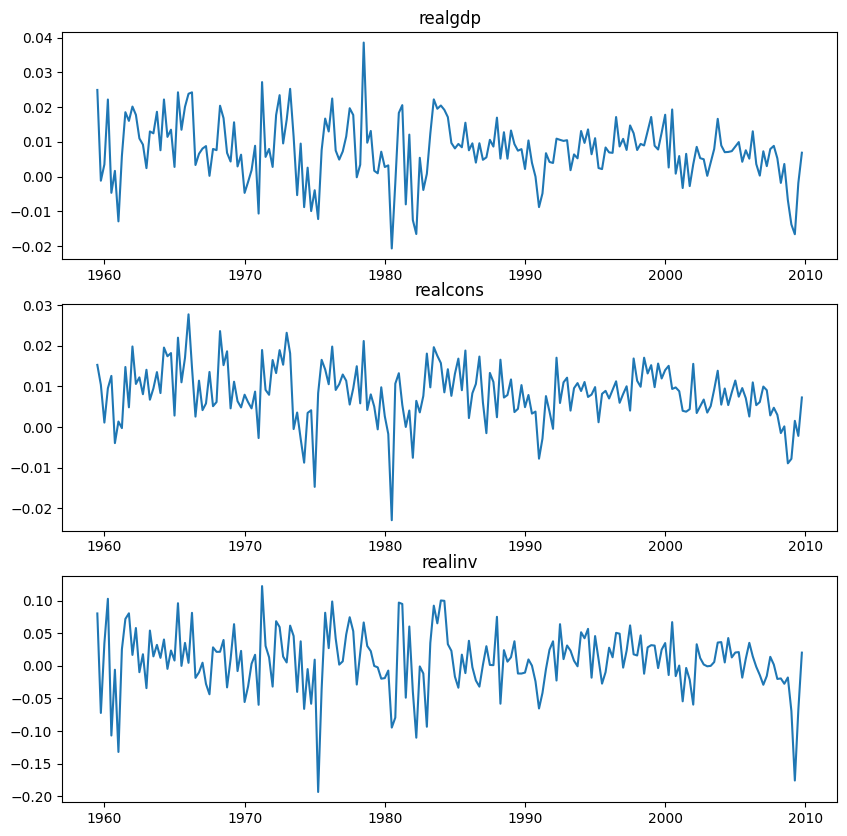

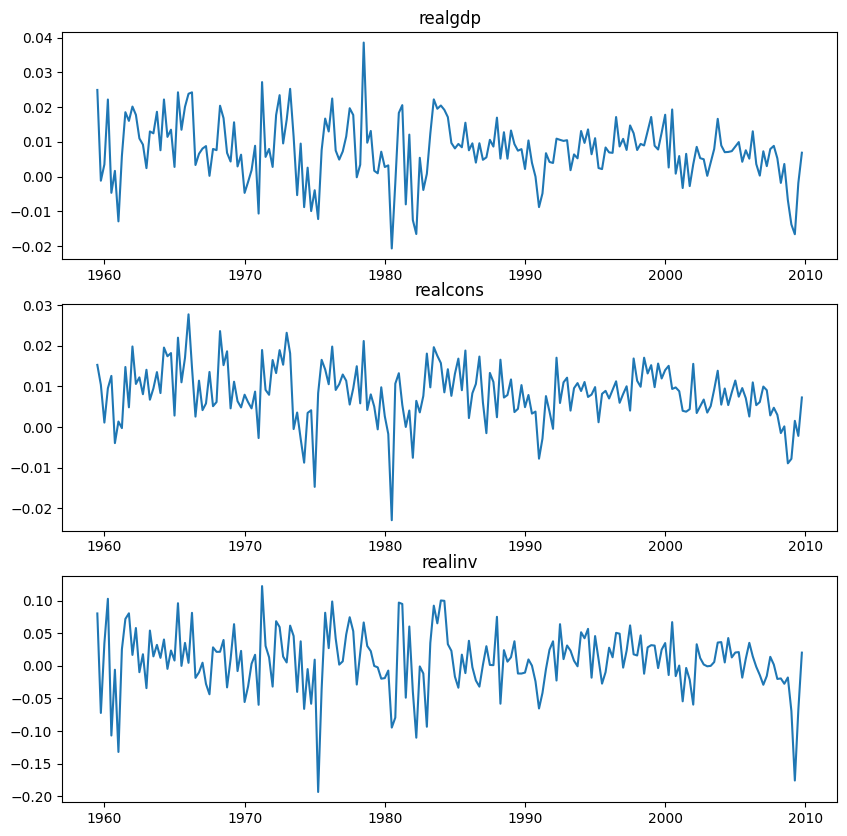

In [20]:
results.plot()

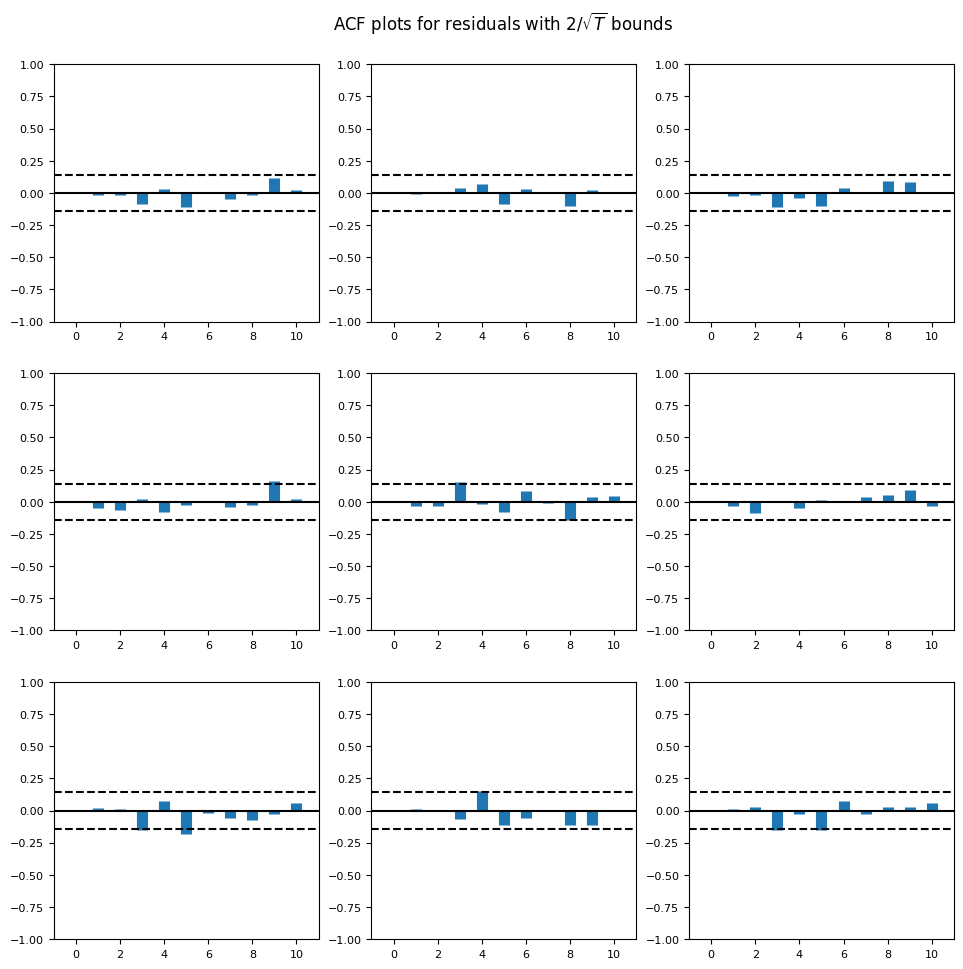

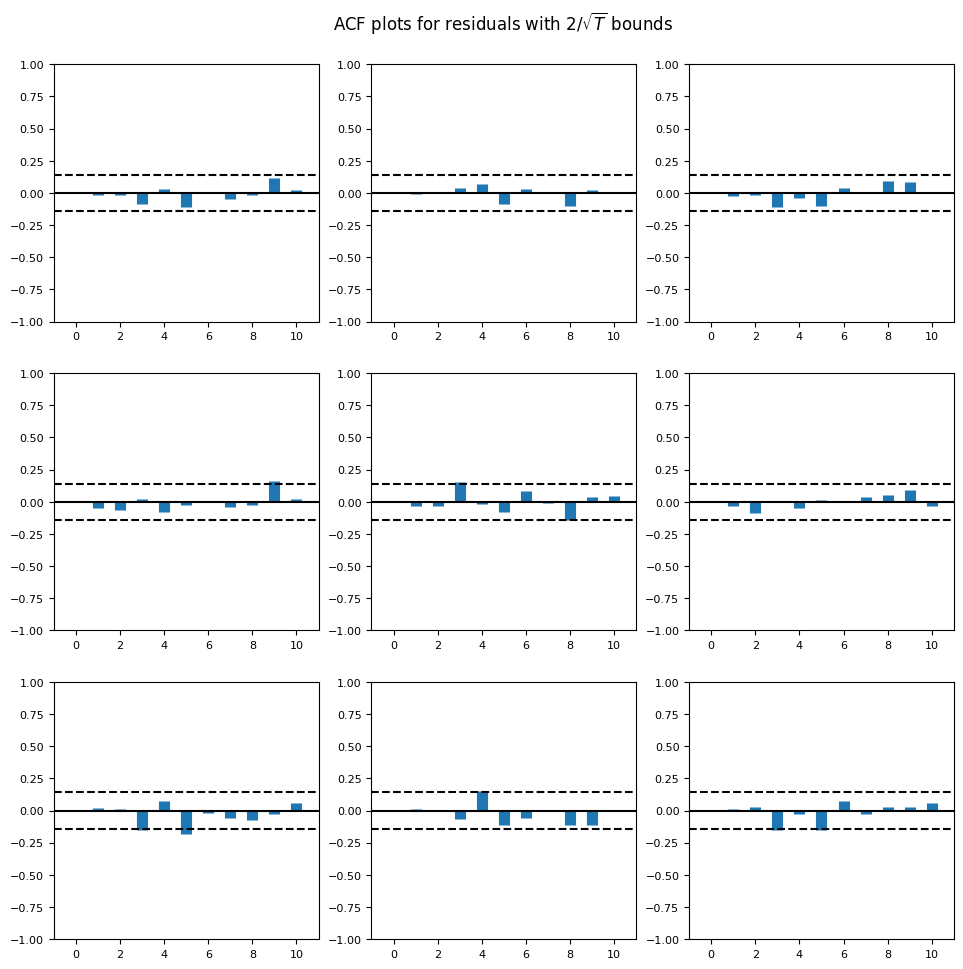

In [21]:
results.plot_acorr()

**Lag order selection**

Choice of lag order can be a difficult problem.\
Standard analysis employs likelihood test or information criteria-based order selection.\
We have implemented the latter, accessible through the VAR class:\
model.select_order(15)

When calling the fit function, one can pass a maximum number of lags and the order criterion to use for order selection:\
model.fit(maxlags=15, ic='aic')

In [10]:
model.select_order(15)

In [11]:
results = model.fit(maxlags=15, ic='aic')

In [12]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 28, Jul, 2024
Time:                     12:22:38
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.4257
Nobs:                     199.000    HQIC:                  -27.7212
Log likelihood:           1961.15    FPE:                7.47593e-13
AIC:                     -27.9222    Det(Omega_mle):     6.45336e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001281         0.001295            0.989           0.322
L1.realgdp         -0.286148         0.171582           -1.668           0.095
L1.realcons         0.673869         0.132245            5.096    

# Forecasting

The linear predictor is the optimal h-step ahead forecast in terms of mean-squared error:

$$y_t(h) = \nu + A_1 y_t(h-1) + \cdots + A_p y_t(h-p) $$

We can use the forecast function to produce this forecast. Note that we have to specify the “initial value” for the forecast:

In [13]:
lag_order = results.k_ar
results.forecast(data.values[-lag_order:], 5)

array([[ 0.00616044,  0.00500006,  0.00916198],
       [ 0.00427559,  0.00344836, -0.00238478],
       [ 0.00416634,  0.0070728 , -0.01193629],
       [ 0.00557873,  0.00642784,  0.00147152],
       [ 0.00626431,  0.00666715,  0.00379567]])

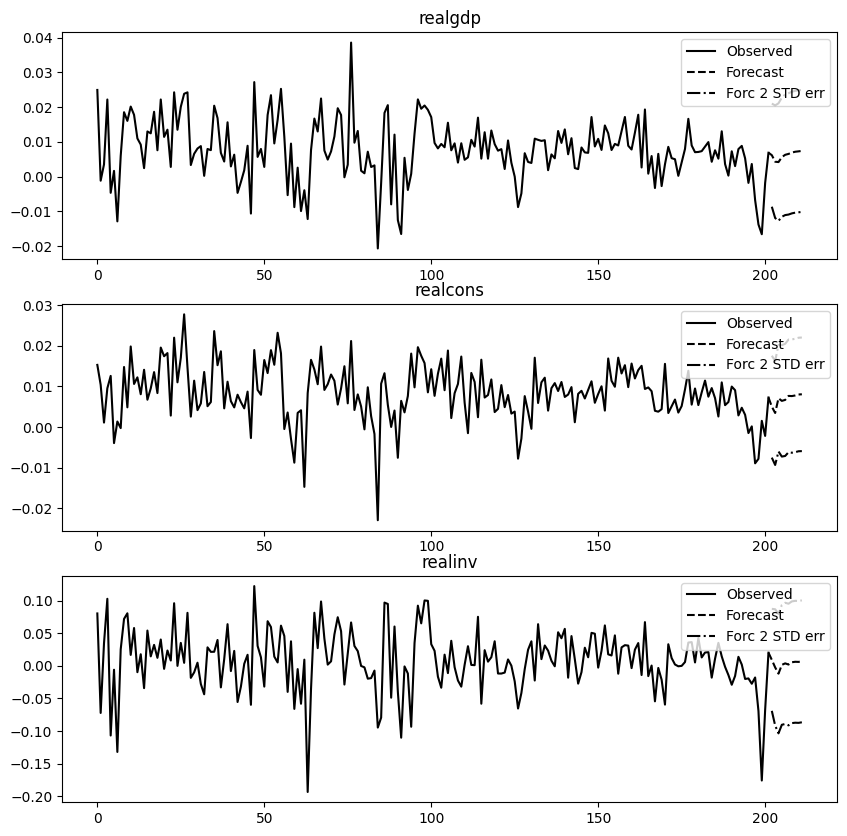

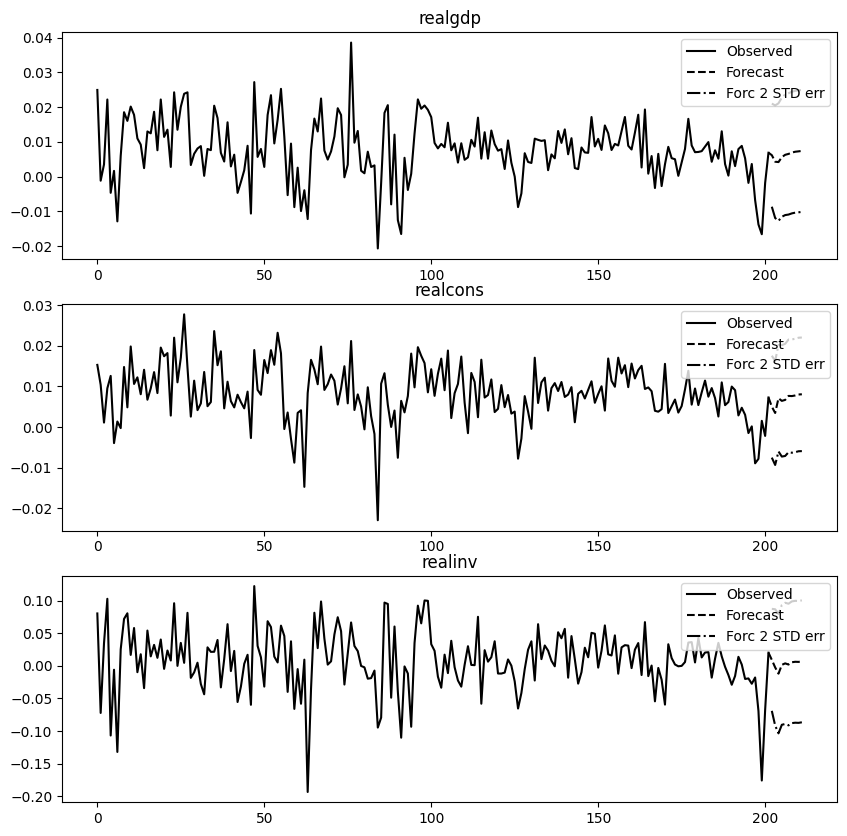

In [14]:
results.plot_forecast(10)

# Impulse Response Analysis

Impulse responses are of interest in econometric studies: they are the estimated responses to a unit impulse in one of the variables.\
They are computed in practice using the MA($\infty$) representation of the VAR(p) process:

$$Y_t = \mu + \sum_{i=0}^{\infty} \Phi_i u_{t-i} $$

We can perform an impulse response analysis by calling the irf function on a VARResults object:

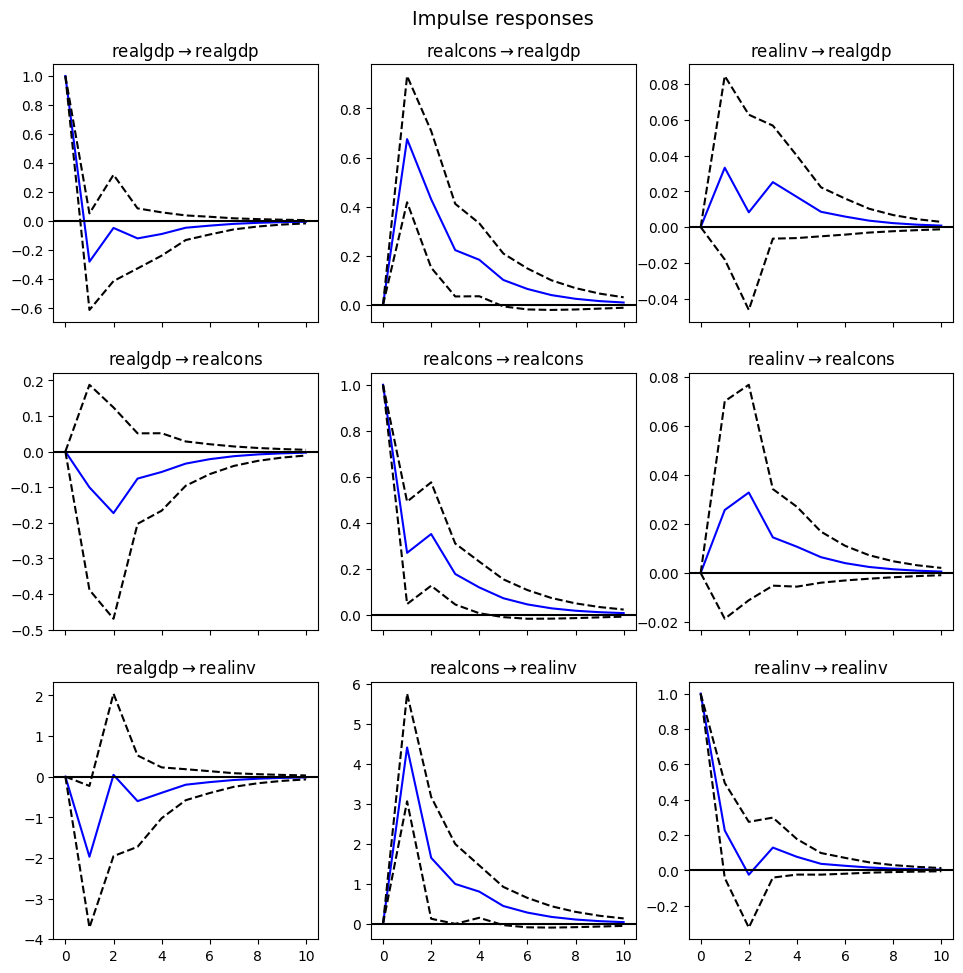

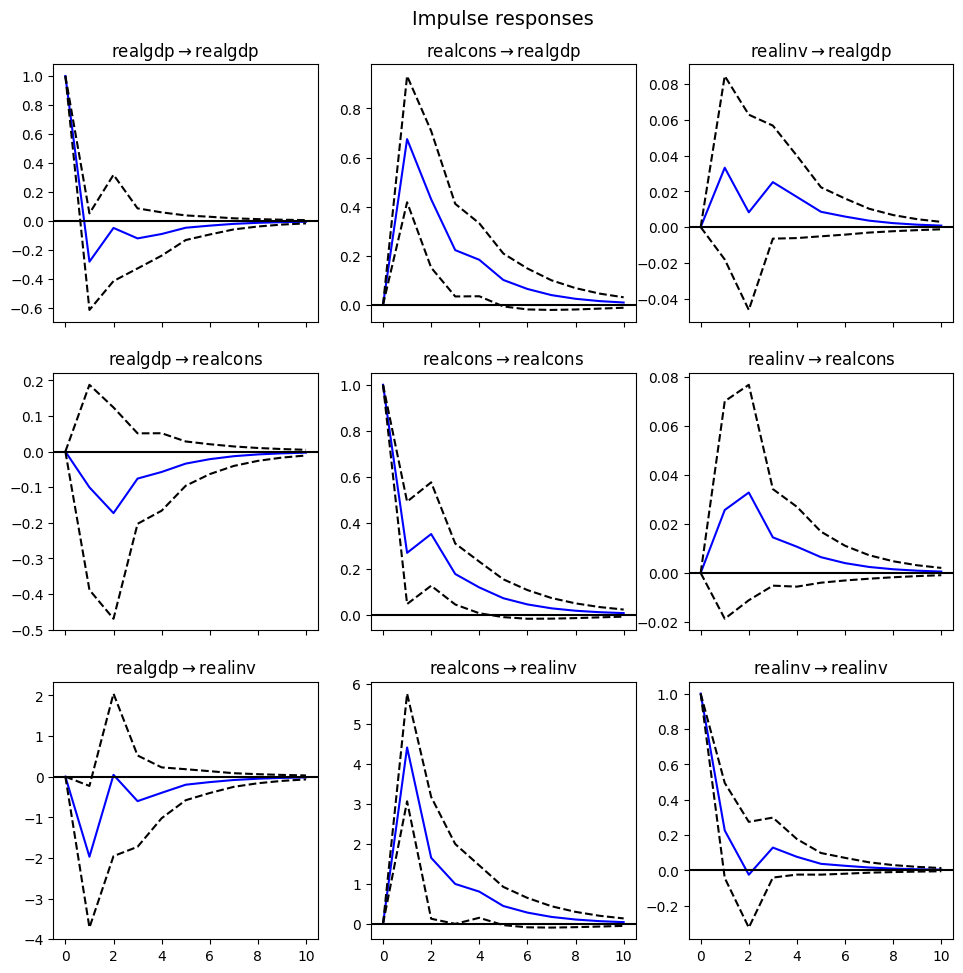

In [25]:
irf = results.irf(10)
irf.plot(orth=False)